<a href="https://colab.research.google.com/github/gunjanak/Reinforcement_Learning/blob/main/Actor_critic_Acrobot_train_test_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import gym
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
env = gym.make('Acrobot-v1')


/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [2]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.action = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc(x))
     

        action_probs = F.softmax(self.action(x), dim=-1)
        state_values = self.value(x)
        return action_probs, state_values

In [3]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

    def predict(self, s):
        """
        Compute the output using the Actor Critic model
        @param s: input state
        @return: action probabilities, state_value
        """
        return self.model(torch.Tensor(s))

    def update(self, returns, log_probs, state_values):
        """
        Update the weights of the Actor Critic network given the training samples
        @param returns: return (cumulative rewards) for each step in an episode
        @param log_probs: log probability for each step
        @param state_values: state-value for each step
        """
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage

            value_loss = F.smooth_l1_loss(value, Gt)

            loss += policy_loss + value_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        """
        Estimate the policy and sample an action, compute its log probability
        @param s: input state
        @return: the selected action, log probability, predicted state-value
        """
        action_probs, state_value = self.predict(s)
        action = torch.multinomial(action_probs, 1).item()
        log_prob = torch.log(action_probs[action])
        return action, log_prob, state_value


In [4]:
def actor_critic(env, estimator, n_episode, gamma=1.0):
    """
    Actor Critic algorithm
    @param env: Gym environment
    @param estimator: policy network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    """
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values = []
        state = env.reset()
        while True:
            action, log_prob, state_value = estimator.get_action(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)
            if is_done:

                returns = []

                Gt = 0
                pw = 0

                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

                estimator.update(returns, log_probs, state_values)
                #print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))

                if total_reward_episode[episode] >= 195:
                    estimator.scheduler.step()

                break

            state = next_state


In [5]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 500
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)
n_episode = 1000
gamma = 0.9
total_reward_episode = [0] * n_episode

actor_critic(env, policy_net, n_episode, gamma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


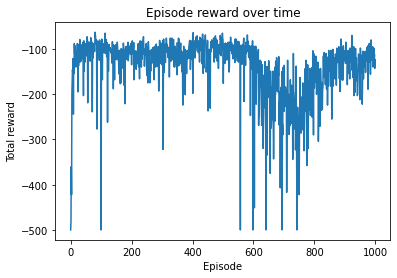

In [6]:
import matplotlib.pyplot as plt

plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

#Testing the trained model for 100 episodes and calculating the average reward


In [ ]:
episodes = 100
total_reward = []
total_positive_reward = []
count = 0
for episode in range(episodes):
  print(episode)
  state = env.reset()
  is_done = False
  total_reward_episode = 0
  positive_reward_count = 0
  while not is_done:
    action, log_prob, state_value  = policy_net.get_action(state)
    next_state, reward, is_done, _ = env.step(action)
    state = next_state
    total_reward_episode += reward
    if(reward > -1):
      positive_reward_count += 1

  #print(total_reward_episode)
  if(total_reward_episode > -120):
    count = count + 1
  total_reward.append(total_reward_episode)
  total_positive_reward.append(positive_reward_count)

In [8]:
print(count)
print(sum(total_reward)/episodes)

37
-137.6


#Saving the model

In [9]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(policy_net, 'actor_critic_acrobat.pkl')